In [1]:
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import log_loss

In [2]:
df = pd.read_json("./train.json")
df.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


In [3]:
df2 = pd.read_json("./test.json")
df2.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street


In [4]:
#handle outliners
#bathroom
df = df.loc[ (df['bathrooms'] > 0) & (df['bathrooms'] != 10)]
z_bath = np.abs(stats.zscore(df['bathrooms']))
df = df[(z_bath < 3)]

#bedroom
z_bed = np.abs(stats.zscore(df['bedrooms']))
df = df[(z_bed < 3)]

#latitude
df = df.loc[
    (df['latitude'] >= 19.50139) & 
    (df['latitude'] <= 64.85694)
    ]
z_lati = np.abs(stats.zscore(df['latitude']))
df = df[(z_lati < 3)]

#longitude
df = df.loc[
    (df['longitude'] >= -161.75583) & 
    (df['longitude'] <= -68.01197)
    ]
z_long = np.abs(stats.zscore(df['longitude']))
df = df[(z_long < 3)]

#price
z_price = np.abs(stats.zscore(df['price']))
df = df[(z_price < 3)]

df = df[(df['description'] != '') & (df['description'] != '<p><a  website_redacted')]
df = df[df['display_address'] != '']
df = df[df['features'].str.len() > 0]
df = df[(df['interest_level'] == 'low') | (df['interest_level'] == 'medium') | (df['interest_level'] == 'high')]

df = df[df['latitude'] != 0]
df = df[df['longitude'] != 0]
df = df[df['photos'].str.len() > 0]
df = df[df['street_address'].str.len() > 0]

df.shape

(40729, 15)

In [5]:
#convert 'created' to numerical attributes
#this step will take about 1min to process
indexes = list(df.index.values.tolist())
time = list(df['created'][indexes])

new_time = []
for i in range(len(time)):
    new_time.append(time[i])
new_time.sort()
new_time1 = list(dict.fromkeys(new_time))

interval_leng = 0
if(len(new_time1) % 5 ==0):
    interval_leng = len(new_time1) / 5
else:
    interval_leng = math.floor(len(new_time1) / 5) + 1
    
time_interval = [[0 for x in range(2)] for y in range(interval_leng)] 
counter = 0
label = 1
time_interval[0][0] = new_time1[0]
time_interval[0][1] = 0
for i in range(len(new_time1)):
    if(counter == 5):
        counter = 0
        time_interval[label][0] = new_time1[i]
        time_interval[label][1] = label
        label += 1
    else:
        counter += 1
        
create_time = []
for i in range(len(time)):
    for j in range(len(time_interval)):
        if(time[i] < str(time_interval[j][0])):
            create_time.append(time_interval[j][1]-1)
            break
        elif(j == (len(time_interval)-1)):
            create_time.append(time_interval[j][1])
            break
            
df.insert(4, "create time interval", create_time, True) 
df.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,5735,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,4488,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


In [6]:
#convert 'created' to numerical attributes(for test.json)
#this step will take about 1min to process
indexes_t = list(df2.index.values.tolist())
time_t = list(df2['created'][indexes_t])

new_time_t = []
for i in range(len(time_t)):
    new_time_t.append(time_t[i])
new_time_t.sort()
new_time_t1 = list(dict.fromkeys(new_time_t))

interval_leng_t = 0
if(len(new_time_t1) % 5 ==0):
    interval_leng_t = len(new_time_t1) / 5
else:
    interval_leng_t = math.floor(len(new_time_t1) / 5) + 1
    
time_interval_t = [[0 for x in range(2)] for y in range(interval_leng_t)] 
counter_t = 0
label_t = 1
time_interval_t[0][0] = new_time_t1[0]
time_interval_t[0][1] = 0
for i in range(len(new_time_t1)):
    if(counter_t == 5):
        counter_t = 0
        time_interval_t[label_t][0] = new_time_t1[i]
        time_interval_t[label_t][1] = label_t
        label_t += 1
    else:
        counter_t += 1
        
create_time_t = []
for i in range(len(time_t)):
    for j in range(len(time_interval_t)):
        if(time_t[i] < str(time_interval_t[j][0])):
            create_time_t.append(time_interval_t[j][1]-1)
            break
        elif(j == (len(time_interval_t)-1)):
            create_time_t.append(time_interval_t[j][1])
            break
            
df2.insert(4, "create time interval", create_time_t, True) 
df2.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,9607,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,11490,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street


In [7]:
#tokenize 'features' then create vector
#from milestone 1
indexes = list(df.index.values.tolist())
values = list(df['features'][indexes])
text_list = []
holder = 0
for i in range(len(values)):
    for ele in values[i]:
        if(len(ele)>50):
            temp = []
            temp = re.split(r'[**]', ele)
            for j in range(len(temp)):
                text_list.append(temp[j])  
        else:
            text_list.append(ele)
        holder += 1 
        
#milestone 2
freq_word = Counter(text_list).most_common(20)
freq_count = []

for i in range(len(values)):
    freq = 0
    for ele in values[i]:
        #print(ele)
        for word in freq_word:
            if(word[0] == ele):
                #print('yes')
                freq += 1
    freq_count.append(freq)
#print(freq_count)

df.insert(7, "common word count", freq_count, True) 
df.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,common word count,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,5735,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,7,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,4488,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,6,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


In [8]:
#tokenize 'features' then create vector(for test.json)
#from milestone 1
indexes_t = list(df2.index.values.tolist())
values_t = list(df2['features'][indexes_t])
text_list_t = []
holder_t = 0
for i in range(len(values_t)):
    for ele in values_t[i]:
        if(len(ele)>50):
            temp_t = []
            temp_t = re.split(r'[**]', ele)
            for j in range(len(temp_t)):
                text_list_t.append(temp_t[j])  
        else:
            text_list_t.append(ele)
        holder_t += 1 
        
#milestone 2
freq_word_t = Counter(text_list_t).most_common(20)
freq_count_t = []

for i in range(len(values_t)):
    freq_t = 0
    for ele in values_t[i]:
        #print(ele)
        for word in freq_word_t:
            if(word[0] == ele):
                #print('yes')
                freq_t += 1
    freq_count_t.append(freq_t)
#print(freq_count)

df2.insert(7, "common word count", freq_count_t, True) 
df2.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,common word count,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,9607,Large with awesome terrace--accessible via bed...,Suffolk Street,6,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,11490,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,3,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street


# 1. First Classifier 

use simple Cross-validation, and DecisionTreeClassifier without pruning

In [9]:
df_x = df[['bathrooms',
           'bedrooms',
           'price',
           'common word count',
           'create time interval']]

df_y = df[['interest_level']]

In [10]:
df_x_t = df2[['bathrooms',
           'bedrooms',
           'price',
           'common word count',
           'create time interval']]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    df_x, 
    df_y, 
    stratify = df_y, 
    test_size = 0.33, 
    random_state = 1)

In [12]:
clf = DecisionTreeClassifier(
    random_state = 1, 
    criterion = 'gini')

my_tree = clf.fit(x_train, y_train)

print(f'Train_data_accuracy:{my_tree.score(x_train, y_train)}')
print(f'Validation_data_accuracy:{my_tree.score(x_test, y_test)}')

Train_data_accuracy:0.9991204925241864
Validation_data_accuracy:0.5881258834908117


In [13]:
proba_list = my_tree.predict_proba(df_x_t)

high_p = []
med_p = []
low_p = []
for i in range(len(proba_list)):
    high_p = proba_list[i][0]
    med_p = proba_list[i][1]
    low_p = proba_list[i][2]
    
first_test_df = df2[['listing_id']]
first_test_df.insert(1, 'high',high_p, True) 
first_test_df.insert(2, 'medium',med_p, True) 
first_test_df.insert(3, 'low',low_p, True)

In [14]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
first_test_df.to_csv('out.zip', index=False,
          compression=compression_opts) 

In [15]:
#dot_data = tree.export_graphviz(clf, out_file=None, 
                         #feature_names=['bathrooms',
                                        #'bedrooms',
                                        #'price',
                                        #'common word count',
                                        #'create time interval'],  
                         #class_names='interest_level',  
                         #filled=True, rounded=True,  
                         #special_characters=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())

# 2. Improvment

In [16]:
new_df_x = df[['bathrooms',
           'bedrooms',
           'price',
           'common word count',
           'create time interval']]

new_df_y = df[['interest_level']]

new_df_x.shape

(40729, 5)

In [17]:
#use Stratified k-fold for Cross-Validation
skf = StratifiedKFold(n_splits = 5)

for train_index, test_index in skf.split(new_df_x, new_df_y):
    new_x_train, new_x_test =  new_df_x.iloc[train_index], new_df_x.iloc[test_index]
    new_y_train, new_y_test = new_df_y.iloc[train_index], new_df_y.iloc[test_index]
    
new_y_train.shape

(32584, 1)

In [18]:
#Pre-pruning: use Grid Search to find best parameter
parameters = {'min_samples_split': range(5,20,2),
              'max_depth': range(1,20,2), 
              'min_samples_leaf': range(2,10,1)}

clf_temp = DecisionTreeClassifier()
clf_tt = GridSearchCV(clf_temp,parameters)
clf_tt.fit(new_x_train, new_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 20, 2),
                    

In [19]:
#Post_pruning: use minimal cost complexity pruning
clf_new = clf_tt.best_estimator_

path = clf_new.cost_complexity_pruning_path(new_x_train, new_y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf_new_1 = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    clf_new_1.fit(new_x_train, new_y_train)
    clfs.append(clf_new_1)

validation_score = 0
for clf_new_1 in clfs:
    temp = clf_new_1.score(new_x_test, new_y_test)
    if(temp > validation_score):
        validation_score = temp
        final_clf = clf_new_1

print(f'Train_data_accuracy:{final_clf.score(x_train, y_train)}')
print(f'Validation_data_accuracy: {final_clf.score(x_test, y_test)}')
#print(f'Test_data_accuracy: {final_clf.score(df_x_t, test_result)}')
#test_scores = [clf.score(new_x_test, new_y_test) for clf in clfs]

Train_data_accuracy:0.6921723834652594
Validation_data_accuracy: 0.6862584629119857


Confusion matrix with normalization
[[0.12752722 0.73561431 0.13685848]
 [0.00765725 0.95350957 0.03883318]
 [0.02379772 0.87357462 0.10262766]]


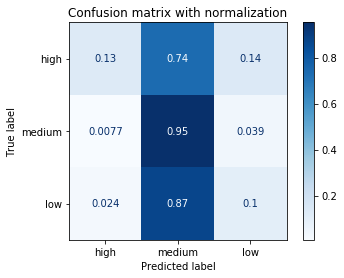

In [20]:
#confusion matrix
titles_options = [("Confusion matrix with normalization", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(estimator = final_clf, 
                                 X = new_x_test, 
                                 y_true = new_y_test,
                                 display_labels=['high','medium','low'],
                                 cmap=plt.cm.Blues,
                                 normalize= 'true')
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [21]:
#logarithmic loss
predict_list = final_clf.predict_proba(new_x_test)
log_loss(new_y_test, predict_list)

0.7347803684765569

In [22]:
proba_list = final_clf.predict_proba(df_x_t)

high_p = []
med_p = []
low_p = []
for i in range(len(proba_list)):
    high_p = proba_list[i][0]
    med_p = proba_list[i][1]
    low_p = proba_list[i][2]
    
final_test_df = df2[['listing_id']]
final_test_df.insert(1, 'high',high_p, True) 
final_test_df.insert(2, 'medium',med_p, True) 
final_test_df.insert(3, 'low',low_p, True)

In [23]:
compression_opts = dict(method='zip',
                        archive_name='prediction_improved_classifier.csv')  
final_test_df.to_csv('prediction_improved_classifier.zip', index=False,
          compression=compression_opts) 